*If running in Google Colab, uncomment the cell below. Skip if running locally.*

In [1]:
# !rm -rf temp_repo src
# !git clone https://github.com/ringhilterra/analytics_cup_research.git temp_repo
# !mv temp_repo/src .
# !rm -rf temp_repo
# !pip install mplsoccer -q

# The Active Support Index (ASI)
### Quantifying Off-Ball Movement When It Matters Most

**Author: Ryan Inghilterra**

---

**Core Question:** When a player is pressured, how actively are teammates moving to provide passing options?

**Metrics Framework:**

| Level | Metric | Formula | Interpretation |
|-------|--------|---------|----------------|
| Per Event | **Active Support Ratio** | $\frac{\text{Active Supporters}}{\text{Nearby Teammates}}$ | Support quality in a single pressure moment |
| Per Player | **Player ASI** | $\frac{\text{Active Support Count}}{\text{Support Opportunities}}$ | How often a player moves to support under pressure |
| Per Team | **Team ASI** | $1 - \text{Static Rate}$ | Team's off-ball movement culture |

**Definitions:**
- **Active Supporter**: Teammate within 35m AND moving >2 m/s
- **Static Rate**: Proportion of events with zero active supporters

Higher values = better off-ball support.

**Validation highlights:**
- ASI correlates with season-level physical output (r = 0.74, p < 0.001)
- ASI aligns with positional demands (midfielders 59% vs defenders 45%, p < 0.001)
- Team ASI differentiates playing styles (98.3% Perth Glory to 91.5% Macarthur FC)
- 58% of players show declining support in H2 (fatigue signal)

In [2]:
# Core imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
plt.style.use('dark_background')

# src imports - core
from src import ASIDataLoader, ASICalculator
from src import fetch_match_data, process_all_matches, get_top_players_all_matches, get_team_stats_all_matches, plot_multi_match_team_comparison
from src.asi_data_loader import ASIDataLoader, print_match_summary
from src.asi_core import ASICalculator, ASIConfig
from src.asi_visualizations import ASIVisualizer
from src.nb_helper import get_detail_results_summary, team_stat_asi_summary, get_event_by_id, plot_pressure_from_event_id

# src imports - validation & analysis
from src import calculate_position_stats, plot_position_validation, test_position_significance, print_significance_result
from src import calculate_time_based_asi, get_time_bin_stats, plot_time_trend, compare_halves, print_half_comparison
from src import calculate_player_fatigue, plot_fatigue_comparison, print_fatigue_summary
from src import load_physical_aggregates, merge_asi_with_physical, calculate_physical_correlation, plot_asi_physical_correlation, print_physical_validation_summary

## Single Match Analysis

In [3]:
MATCH_ID = 1886347 # Auckland (Home) vs Newcastle (Away) - final score: (2, 0)
# MATCH_ID = 1899585 ## <- can easily change match_id

---

### Data Loading

In [4]:
# First fetch/download data for single match - tracking and event data from SkillCorner GitHub
fetch_match_data(MATCH_ID, verbose=True, skip_if_exists=True)  # Downloads and processes match data to ./data/1886347/

Match 1886347 data already exists, skipping fetch.


PosixPath('data/1886347')

In [5]:
# Load match
loader = ASIDataLoader(data_dir="./data")
match_data = loader.load_match(MATCH_ID)

# Print summary
print_match_summary(match_data)

MATCH 1886347
Auckland FC 2 - 0 Newcastle United Jets FC
------------------------------------------------------------
Tracking rows:    956,076
Event rows:       5,079
Pressure events:  773
Pitch:            104m x 68m
Validated:        Yes


In [6]:
# show processed tracking data with velocity (speed)
display_cols = ['frame', 'team_id', 'short_name','number', 'x', 'y', 'vx', 'vy', 'speed', 'match_time_min', 'ball_x', 'ball_y', 'player_role.acronym']
match_data.tracking_df.head(3)[display_cols]

,frame,team_id,short_name,number,x,y,vx,vy,speed,match_time_min,ball_x,ball_y,player_role.acronym
0,10,4177,L. Verstraete,6,11.70,6.73,-1.242857,-0.407143,1.307845,0.0,0.32,0.38,DM
1,10,4177,F. Gallegos,28,10.16,-2.12,-0.292857,-1.042857,1.083197,0.0,0.32,0.38,AM
2,10,4177,N. Pijnaker,4,16.78,-3.67,0.257143,-0.289286,0.387051,0.0,0.32,0.38,LCB


In [7]:
match_data.events_df.iloc[:, :8].tail(3) # peak at dynamic_events

,event_id,frame_start,frame_end,event_type,event_subtype,player_id,team_id,player_name
5076,8_998,58907,58932,player_possession,NaN,285188,4177,A. Paulsen
5077,7_2542,58907,58932,passing_option,NaN,43829,4177,N. Moreno
5078,7_2543,58907,58932,passing_option,NaN,163972,4177,M. Mata


---

### Calculating ASI Per Pressure Event

**Configurable Thresholds:**
| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Proximity | 35m | Maximum realistic passing range under pressure |
| Velocity | 2 m/s | Threshold separating walking (~1.4 m/s) from jogging/running |

In [8]:
# can adjust these values
PROX_THRESH = 35
VELOCITY_THRESH = 2

config = ASIConfig(proximity_threshold_m=PROX_THRESH, velocity_threshold_ms=VELOCITY_THRESH)
print(config.proximity_threshold_m)
print(config.velocity_threshold_ms)

35
2


In [9]:
# Calculate ASI metrics for each pressure event
calculator = ASICalculator(match_data, config=config)
results_df = calculator.process_all_pressure_events()
print(results_df.shape)

(773, 17)


In [10]:

print("\nPressure Event Results (first 8)")
display_cols = ['frame_start', 'period', 'pressed_player_name', 'num_teammates_nearby', 'num_active_supporters', 'active_support_ratio']
results_df[display_cols].head(8)


Pressure Event Results (first 8)


,frame_start,period,pressed_player_name,num_teammates_nearby,num_active_supporters,active_support_ratio
0,56,1,A. Šušnjar,8,4,0.5000
1,74,1,M. Natta,8,6,0.7500
2,235,1,F. De Vries,4,2,0.5000
3,253,1,D. Ingham,9,8,0.8889
4,314,1,L. Gillion,5,5,1.0000
5,345,1,F. Gallegos,6,3,0.5000
6,499,1,A. Šušnjar,7,0,0.0000
7,549,1,F. Gallegos,9,6,0.6667


**Example (Row 1):** A. Šušnjar under pressure
- 8 teammates within 35m → 4 moving >2 m/s → **Active Support Ratio = 0.50**
- Half his nearby teammates were actively creating options; half were static.

In [11]:
# Get detailed result for a single event
detailed_results = calculator.get_detailed_results()
# Show one event in detail
event = detailed_results[1]
get_detail_results_summary(event)


Detailed Analysis - Single Pressure Event
Event ID: 9_1
Frame: 74
Type: recovery_press

Pressed Player: M. Natta
Position: (-16.9, 20.6)

Support Metrics:
  Teammates Nearby (<35m): 8
  Active Supporters (>2m/s): 6
  Active Support Ratio: 0.75

Teammate Details:
  C. Timmins      | Dist:  14.8m | Speed: 3.8 m/s | ACTIVE
  D. Ingham       | Dist:  56.4m | Speed: 1.6 m/s | FAR
  R. Scott        | Dist:  30.2m | Speed: 1.6 m/s | STATIC
  A. Šušnjar      | Dist:  15.9m | Speed: 3.1 m/s | ACTIVE
  P. Cancar       | Dist:  29.2m | Speed: 1.9 m/s | STATIC


---

### Pressure Moment Visualization

Visualize pressure events with active/static support color coding. Use `plot_pressure_from_event_id(event_id, ...)` to generate a visualization for any pressure event.

#### High Active Support Example

In [12]:
# Initialize visualizer
visualizer = ASIVisualizer(match_data)

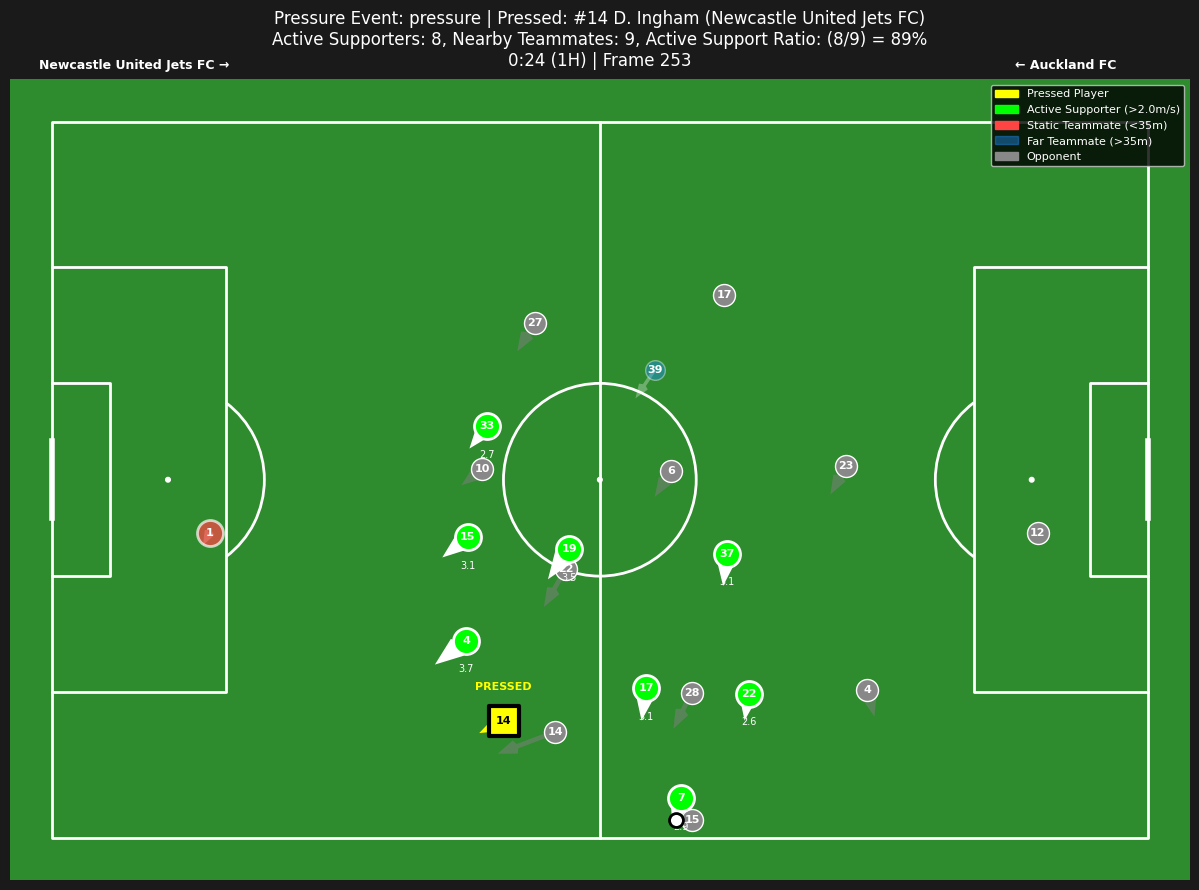

In [13]:
plot_pressure_from_event_id("9_3", detailed_results, match_data, loader)  # frame 253, Player = D.Ingham

D. Ingham (#14, Newcastle) pressed while facing his own goal. **Active Support Ratio = 0.89** — 8 of 9 nearby teammates actively moving. Only the goalkeeper was static (already open). Note #4 sprinting back at 3.7 m/s to offer a passing lane.

#### Low Active Support Example

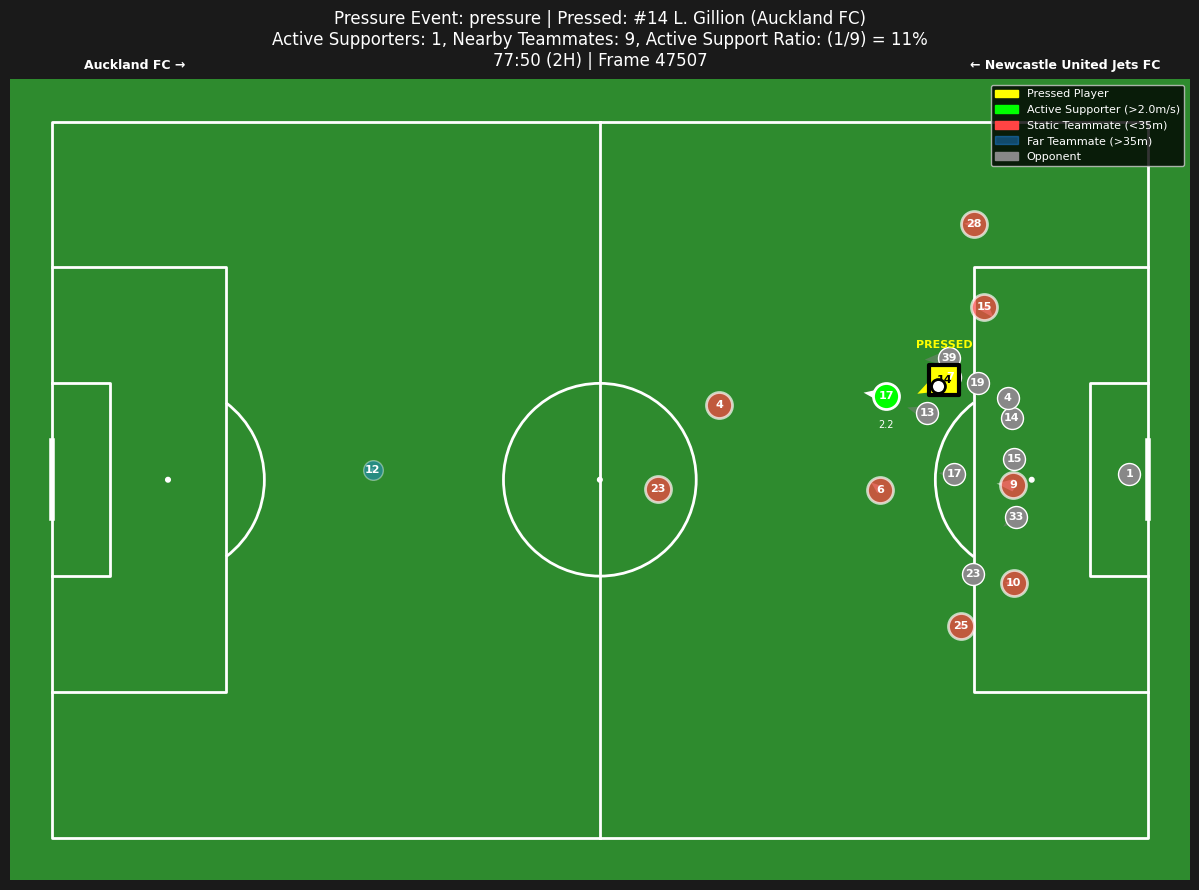

In [14]:
plot_pressure_from_event_id("9_790", detailed_results, match_data, loader)  # frame 47507, Player = L.Gillion

L. Gillion (#14, Auckland) pressed near the 18-yard box. **Active Support Ratio = 0.11** — only 1 of 9 nearby teammates moving (#17 at 2.2 m/s). Most teammates were static "ball-watching" rather than creating options. This is exactly the scenario coaches want to identify and correct.

---

### Player ASI Analysis

Calculate and rank players by their Active Support Index.

In [15]:
# Calculate player ASI scores
player_scores = calculator.calculate_player_asi_scores(detailed_results)
print(f"Player ASI Scores: Total players analyzed: {len(player_scores)}")
# Display top 10 with minimum 20 opportunities
top_players = player_scores[player_scores['opportunities'] >= 20].head(10)
print(f"\nTop 10 Players (min 20 opportunities):")

exclude_cols = ['player_id', 'player_number', 'match_name', 'matches_count']
top_players.drop(columns=exclude_cols).head(10)

Player ASI Scores: Total players analyzed: 29

Top 10 Players (min 20 opportunities):


,player_name,team_name,player_role_acronym,active_support_count,opportunities,asi_score
0,C. Timmins,Newcastle United Jets FC,LDM,214,278,0.7698
1,D. Wilmering,Newcastle United Jets FC,AM,39,54,0.7222
2,F. Gallegos,Auckland FC,AM,231,330,0.7000
3,M. Scarcella,Newcastle United Jets FC,AM,27,39,0.6923
4,L. Gillion,Auckland FC,LW,181,269,0.6729
5,L. Verstraete,Auckland FC,DM,227,345,0.6580
6,J. Vidic,Newcastle United Jets FC,LDM,25,38,0.6579
7,N. Moreno,Auckland FC,RW,46,70,0.6571
8,L. Bayliss,Newcastle United Jets FC,AM,136,210,0.6476
9,L. Rogerson,Auckland FC,RW,120,193,0.6218


**Player ASI** measures how often a player actively moves to support teammates under pressure — the proportion of support opportunities where they were moving >2 m/s.

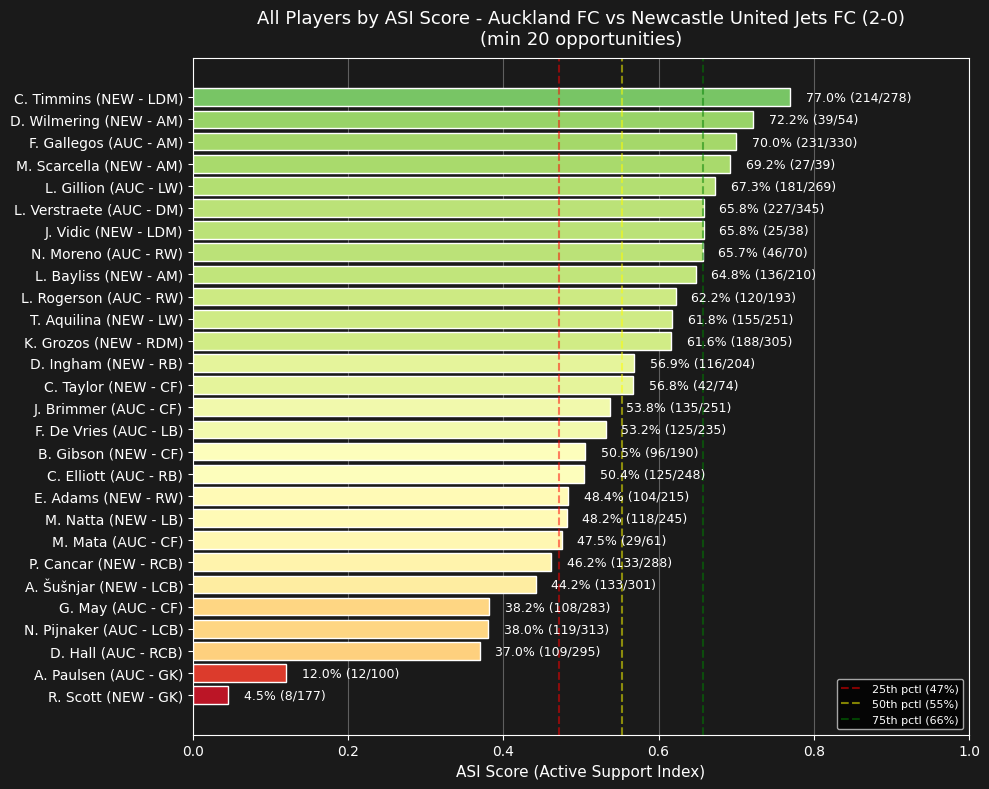

In [16]:
# Player leaderboard visualization
fig = visualizer.plot_player_leaderboard(player_scores, top_n=None, min_opportunities=20, show=True)

Midfielders cluster at the top — their role demands constant movement. Defenders and goalkeepers rank lower, which is expected given their positional responsibilities. **Standout: C. Timmins (LDM)** leads with 77% ASI, providing active support in 214 of 278 opportunities — the most reliable off-ball mover in this match.

---

### Team ASI Comparison

Calculate and compare Active Support Index between teams for the match.

In [17]:
# Calculate team-level ASI
team_stats = calculator.calculate_team_asi_scores(results_df)
# provide summary
team_stat_asi_summary(team_stats)

Team ASI Comparison

Auckland FC:
  Total pressure events (when pressed): 402
  Team ASI (1 - static rate):           96.0%
  Static Rate (0 active supporters):   4.0%
  Avg Active Supporters:                3.92
  Avg Teammates Nearby:                 7.49

Newcastle United Jets FC:
  Total pressure events (when pressed): 371
  Team ASI (1 - static rate):           94.6%
  Static Rate (0 active supporters):   5.4%
  Avg Active Supporters:                4.13
  Avg Teammates Nearby:                 7.73


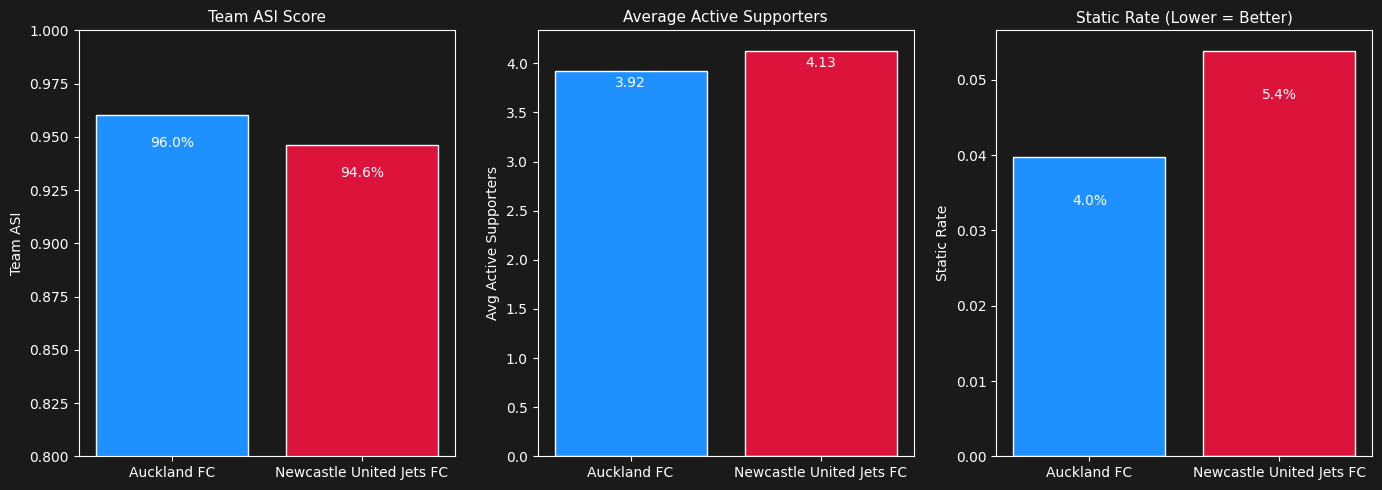

In [18]:
# Team comparison visualization
fig = visualizer.plot_team_comparison(team_stats, show=True)

| Metric                | What it Measures                                                                                | Interpretation                                                                                    |
|-----------------------|-------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| Team ASI              | 1 - static_rate — Proportion of pressure events where at least one teammate was actively moving | Higher = Better. A team with 95% ASI means only 5% of pressure moments had zero active support.   |
| Avg Active Supporters | Mean number of teammates moving >2 m/s within 35m when ball carrier is pressed                  | Higher = Better. More teammates in motion = more passing options and defensive support.           |
| Static Rate           | Proportion of pressure events where no nearby teammate was moving >2 m/s                        | Lower = Better. High static rate indicates teammates "ball-watching" instead of creating options. |

**Quick Read:** Higher Team ASI + Lower Static Rate = better off-ball support culture. Avg Active Supporters shows intensity — teams averaging 3+ are creating strong movement.

## Run on all 10 matches

In [19]:
# Process all 10 matches (will take a couple of minutes)
results_all = process_all_matches(verbose=False)

In [20]:
# Top 10 players across all matches
top_players_all = get_top_players_all_matches(results_all['all_player_scores'], min_opportunities=50, top_n=300)
exclude_cols = ['player_id', 'player_number', 'match_name']
top_players_all.drop(columns=exclude_cols).head(10)

,player_name,team_name,player_role_acronym,active_support_count,opportunities,matches_count,asi_score
0,N. Pennington,Perth Glory Football Club,LM,211,261,1,0.8084
1,H. Steele,Central Coast Mariners Football Club,LM,184,228,1,0.8070
2,C. Timmins,Newcastle United Jets FC,LDM,214,278,1,0.7698
3,L. Verstraete,Auckland FC,DM,688,936,4,0.7350
4,D. Wilmering,Newcastle United Jets FC,AM,39,54,1,0.7222
5,P. Makrillos,Macarthur FC,CF,78,108,1,0.7222
6,J. Lauton,Western United,RM,120,167,2,0.7186
7,Z. Schreiber,Melbourne City FC,DM,178,249,1,0.7149
8,T. Gomulka,Perth Glory Football Club,RM,183,256,1,0.7148
9,A. Thurgate,Western United,LM,372,524,2,0.7099


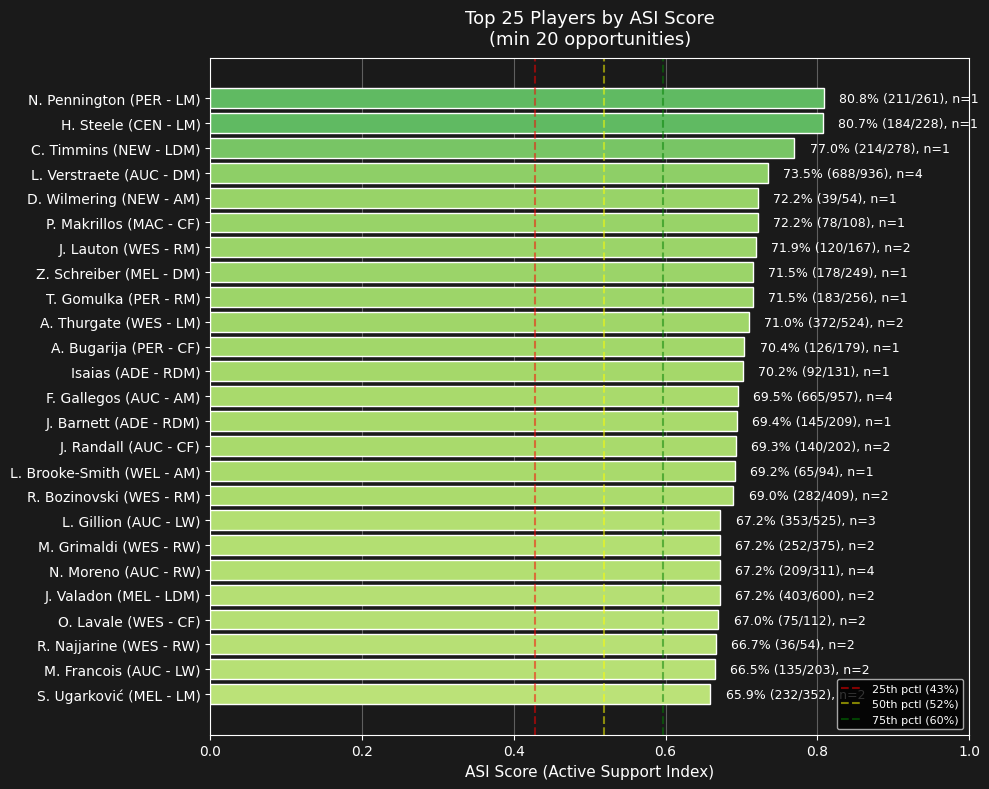

In [21]:
fig = visualizer.plot_player_leaderboard(top_players_all, top_n=25, min_opportunities=20)

Wide midfielders (LM, RM) and central midfielders (DM, AM) dominate the top 25 — positions requiring constant off-ball movement. Only 2 players exceed 80% ASI: **N. Pennington (80.8%)** and **H. Steele (80.7%)**, both left midfielders, marking them as elite off-ball supporters. The 75th percentile threshold (~70%) separates good from exceptional active supporters.

In [22]:
# Team comparison across all matches
team_summary = get_team_stats_all_matches(results_all['all_team_stats'])
team_summary

,team_name,total_pressure_events,total_static_events,avg_active_supporters,avg_teammates_nearby,matches_played,overall_static_rate,overall_team_asi
0,Perth Glory Football Club,287,5,4.30,7.66,1,0.0174,0.9826
1,Auckland FC,1368,37,4.18,7.71,4,0.0270,0.9730
2,Melbourne City FC,828,36,3.62,7.22,2,0.0435,0.9565
3,Western United,647,29,4.40,7.60,2,0.0448,0.9552
4,Brisbane Roar FC,453,21,3.56,7.53,1,0.0464,0.9536
5,Wellington Phoenix FC,598,28,3.72,7.77,2,0.0468,0.9532
6,Adelaide United Football Club,392,19,3.57,7.49,1,0.0485,0.9515
7,Newcastle United Jets FC,371,20,4.13,7.73,1,0.0539,0.9461
8,Central Coast Mariners Football Club,266,15,3.63,7.39,1,0.0564,0.9436
9,Melbourne Victory Football Club,674,39,4.00,7.91,2,0.0579,0.9421


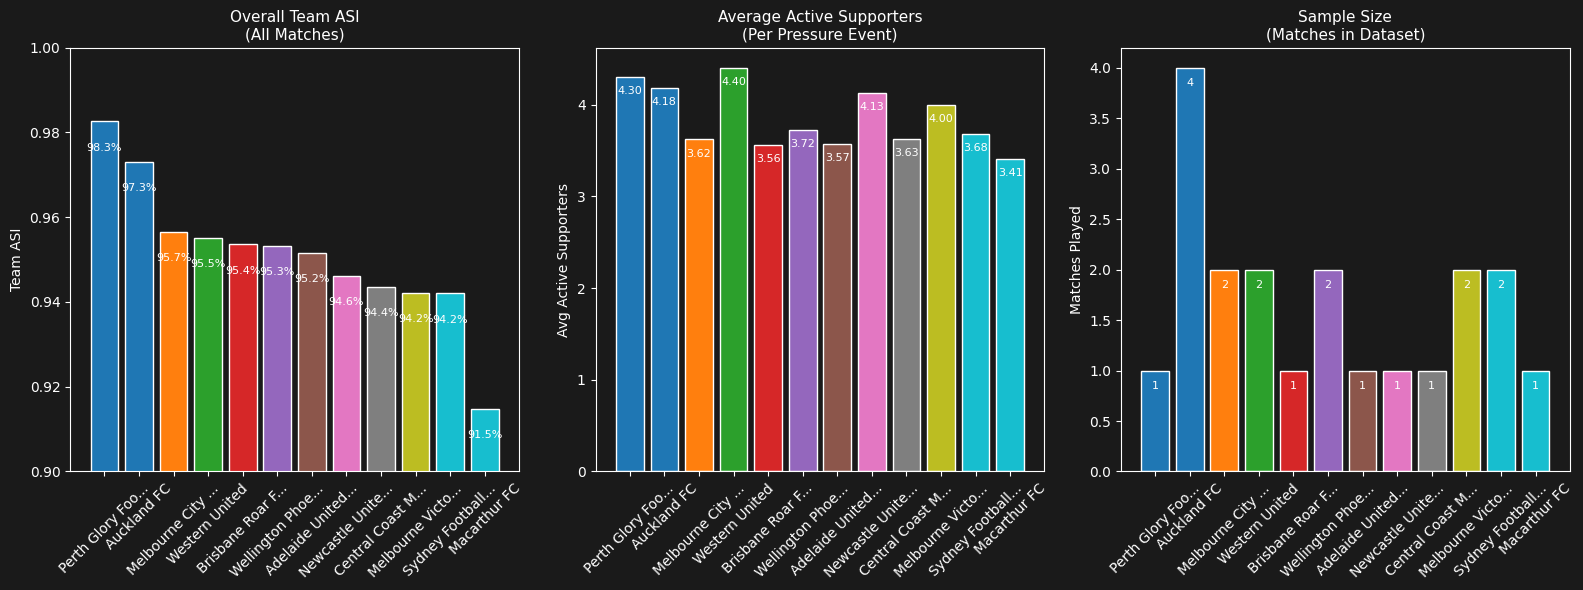

In [23]:
fig = plot_multi_match_team_comparison(team_summary)

Perth Glory (98.3%) and Auckland (97.3%) lead in Team ASI, demonstrating strong off-ball support cultures. Macarthur FC (91.5%) shows the most room for improvement. The 7-point spread suggests ASI can differentiate team playing styles.

---

## Validation: ASI by Position

To validate that ASI captures meaningful off-ball behavior, we examine whether positions with higher movement demands show correspondingly higher ASI scores.

In [24]:
# Calculate ASI stats by position category
category_stats = calculate_position_stats(top_players_all)
category_stats

,mean_asi,std_asi,num_players,total_opportunities
position_category,,,,
Defensive/Central Mid,0.627,0.083,15,5683
Attacking Mid/Winger,0.586,0.099,62,15705
Forward,0.515,0.101,35,9023
Defender,0.452,0.079,61,20367
Goalkeeper,0.113,0.059,12,2334


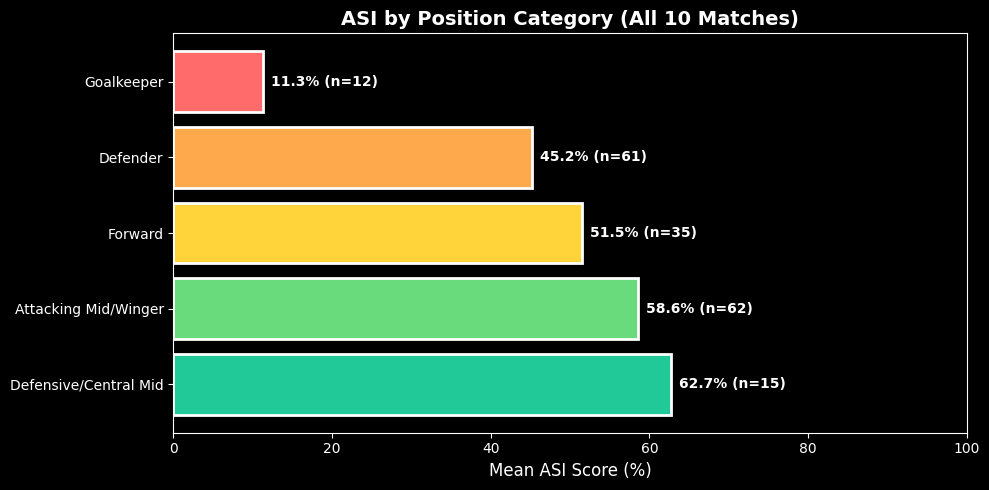

In [25]:
# Visualize ASI by position category
fig = plot_position_validation(category_stats)

In [26]:
# Statistical significance test
result = test_position_significance(top_players_all)
print_significance_result(result)

Midfielders vs Defenders:
  Midfielders mean ASI: 59.4% (n=77)
  Defenders mean ASI: 45.2% (n=61)
  Mann-Whitney U: 4092, p = 4.00e-14 Significant (p < 0.001)


**Validation Result**: Position categories rank as expected — attacking midfielders and wingers show significantly higher ASI than defenders (p < 0.001). This confirms ASI captures positional movement demands rather than random variation.

---

## Validation: Season Physical Output

Does ASI from tracking data reflect real physical effort? We validate by comparing player ASI scores (from 10 tracking matches) against season-level physical aggregates (175 matches, A-League 2024/25).

In [27]:
# Merge ASI scores with physical aggregates
merged_physical = merge_asi_with_physical(top_players_all, min_opportunities=50)
print(f"Players with ASI and physical data: {len(merged_physical)}")

# Calculate and display correlation
corr_stats = calculate_physical_correlation(merged_physical)
print_physical_validation_summary(corr_stats)

Players with ASI and physical data: 167
Physical Aggregates Validation
Players analyzed: 167
Pearson r: 0.739
p-value: 4.47e-30

Quartile Comparison (M/min during possession):
  Low ASI (Q1):  128.8 m/min
  High ASI (Q4): 153.2 m/min
  Difference:    +24.4 m/min (+19%)


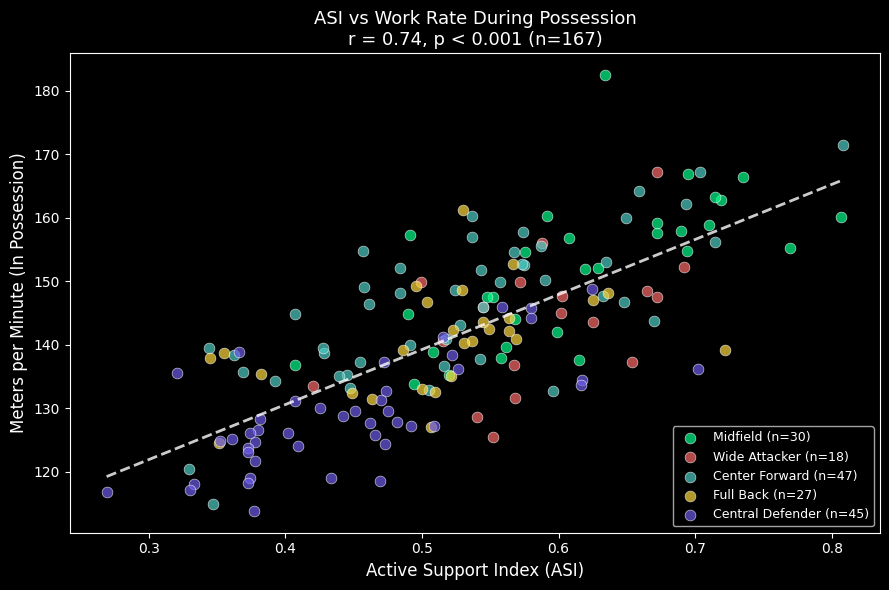

In [28]:
# Visualize ASI vs physical output correlation
fig = plot_asi_physical_correlation(merged_physical)

**Result**: ASI correlates strongly with meters per minute during possession (r = 0.74, p < 0.001). Players in the top ASI quartile cover 24 m/min more than the bottom quartile — a 19% increase in work rate. This external validation confirms ASI captures genuine physical effort: players who actively support teammates under pressure are the same players who cover the most ground when their team has possession.

---

## Time-Based ASI Analysis

Does active support decline as the match progresses? We analyze ASI trends over 15-minute intervals to identify potential fatigue patterns.

In [29]:
# Calculate time-based ASI across all 10 matches
all_results_time_df = calculate_time_based_asi(loader, config)
print(f"Total pressure events with time data: {len(all_results_time_df)}")

Total pressure events with time data: 7063


In [30]:
# Calculate ASI by time bin
time_asi = get_time_bin_stats(all_results_time_df)
time_asi

,avg_support_ratio,avg_active_supporters,num_events
time_bin,,,
0-15,0.552,4.055,1283
15-30,0.534,3.784,990
30-45,0.527,3.770,1128
45-60,0.542,3.956,1302
60-75,0.548,3.984,1013
75-90,0.502,3.683,992
90+,0.513,3.730,355


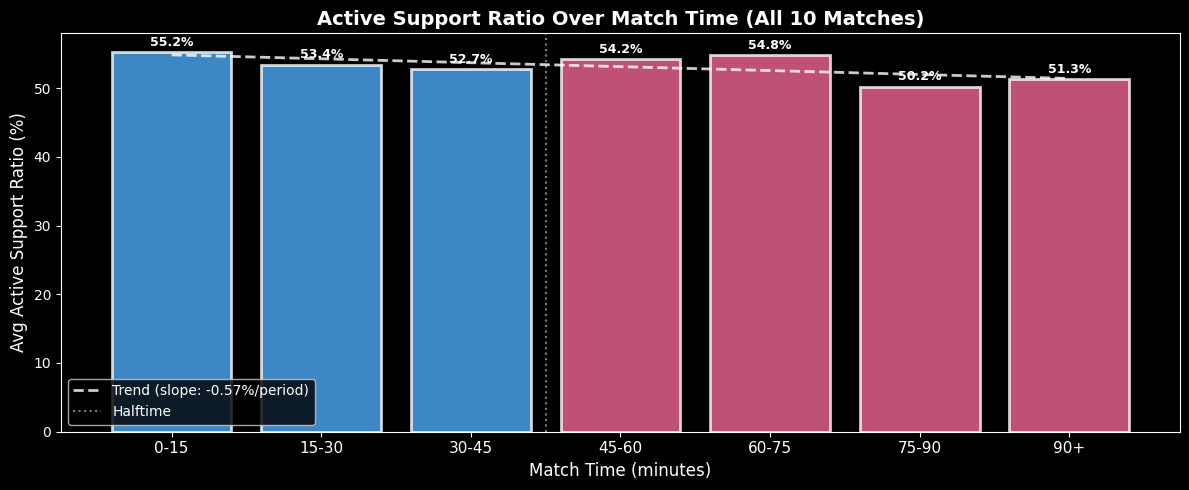

In [31]:
# Visualize ASI trend over match time
fig = plot_time_trend(time_asi)

In [32]:
# Compare First Half vs Second Half
half_result = compare_halves(all_results_time_df)
print_half_comparison(half_result)
half_result['half_stats']


First Half vs Second Half ASI:
  H1 mean: 53.7%, H2 mean: 53.1%
  Mann-Whitney U: 6298558, p = 0.459 (not significant)


,avg_ratio,std_ratio,avg_active,num_events
half,,,,
First Half,0.537,0.303,3.877,3565
Second Half,0.531,0.303,3.872,3498


**Observation**: Active support ratio shows a slight downward trend within each half, with the lowest values appearing in the final 15 minutes (50.2%). However, the overall first half vs second half difference is not statistically significant (p = 0.46). This suggests fatigue-related decline in off-ball support may exist but requires larger sample sizes to confirm. The pattern warrants further investigation with more match data.

---

## Player Fatigue Analysis

Which players maintain their off-ball support throughout the match vs those who fade? We compare each player's ASI in the first half vs second half.

In [33]:
# Calculate player fatigue metrics across all 10 matches
qualified = calculate_player_fatigue(loader, config, min_opps=15)
print(f"Players with 15+ opportunities in both halves: {len(qualified)}")

Players with 15+ opportunities in both halves: 151


In [34]:
# Show top maintainers (lowest fatigue drop)
# Note: Negative fatigue_drop = H2 improvement (player increased ASI after halftime)
qualified[['player_name', 'h1_asi', 'h2_asi', 'fatigue_drop', 'total_opps']].round(3).head(10)

,player_name,h1_asi,h2_asi,fatigue_drop,total_opps
76,J. Yull,0.457,0.699,-0.241,202.0
58,D. Pierias,0.231,0.465,-0.234,209.0
144,L. Bayliss,0.604,0.784,-0.181,210.0
142,E. Adams,0.419,0.595,-0.176,215.0
129,J. Randall,0.606,0.777,-0.171,202.0
68,H. Van Der Saag,0.403,0.554,-0.150,185.0
153,M. Ruhs,0.498,0.643,-0.145,313.0
204,F. Talladira,0.403,0.538,-0.135,233.0
193,A. Bugarija,0.667,0.800,-0.133,179.0
44,J. Brimmer,0.525,0.653,-0.128,661.0


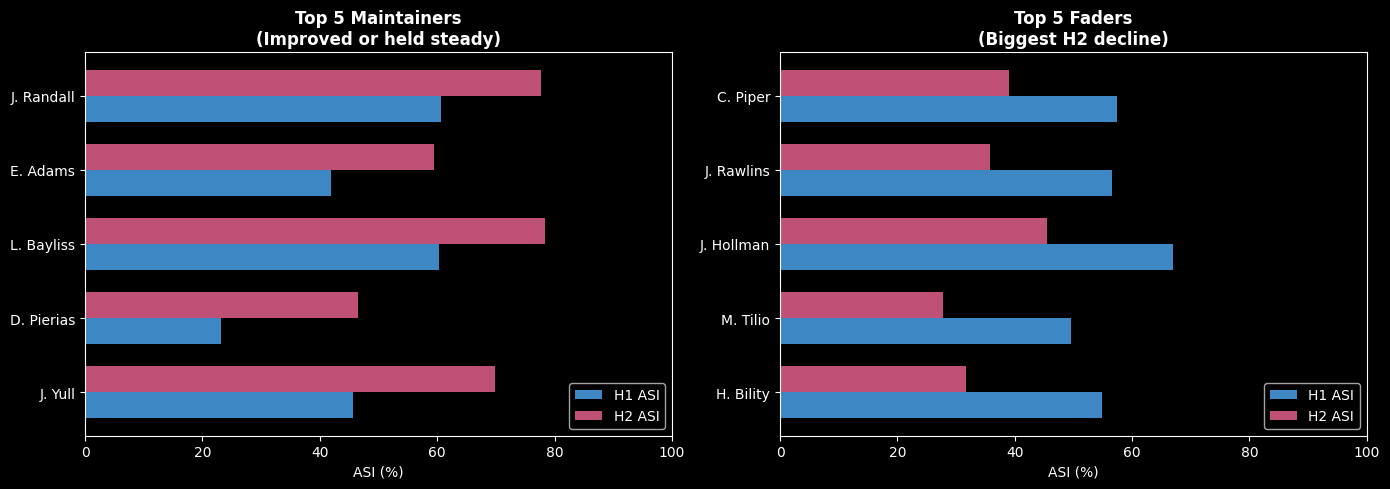


Fatigue Analysis Summary (151 players):
  Players who improved H1→H2: 63
  Players who declined H1→H2: 87
  Avg fatigue drop: 1.0%


In [35]:
# Visualize: Top 5 Maintainers vs Top 5 Faders
fig = plot_fatigue_comparison(qualified, top_n=5)
print_fatigue_summary(qualified)

**Key Finding**: More players show declining off-ball support in the second half (58%) than improving (42%), with an average 1% drop. However, individual variation is substantial — some players significantly increase their movement after halftime (possibly "warming into" the match), while others show clear fatigue patterns. This player-level analysis could help coaches identify which players need earlier substitution or targeted conditioning work.

---

## Impact & Use Cases

| Stakeholder | Application |
|-------------|-------------|
| **Scouts** | Identify "highly-active supporter" players who consistently work off-ball to support teammates under pressure|
| **Coaches** | Diagnose static tendencies; design training to improve support patterns |
| **Analysts** | Compare team playing styles; evaluate support quality by zone |
| **Players** | Objective feedback on off-ball contribution |

## Future Improvements

- **Context-aware "active support"**: Account for whether a player is already open (opponent proximity). A stationary player in space may be better positioned than one running into traffic.
- **Advanced support classification**: Incorporate velocity direction vectors and pass opening angle calculations to distinguish between movement toward useful space versus movement away from the play.